# Data
------------

In [31]:
from data_management.data_acquisition import DataAcquisition
from data_management.data_transformation import DataTransformation
from data_management import FROM_CSV
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns

## 1 Data transformation

| Element of graph |                                                                   Usage in our case                                                                   | 
|:-----------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------:| 
| Nodes            |                                                                         Teams                                                                         | 
| Nodes Features   | altogether home wins, home losses, away win and away losses, all points scored by team, all points lost to another team until the end of the snapshot | 
| Edges            |                                                           Matches between individual teams                                                            | 
| Edge features    |                                           0 - home win, 1 - draw, 2 - away win => match outcome prediction                                            |
| Node labels      |                                                               individual teams ranking                                                                |


What type of graph do we have? - Number of vertices in our graphs is static - it is the number of all teams that we want to train on. Number of edges changes over time. Edges represent matches. So the graph is dynamic. Some vertices may not be connected in each graph snapshot, because there may be season, in which a team may not have played any match within selected league. Although this will create a redundancy in our feature matrix, it is more straightforward to implement, than reindexing teams in each snapshot in order to incorporate only those vertices with edges. So we are dealing with so called 'Dynamic graph temporal signal'.

2024-02-23 19:09:00.646 | INFO     | data_management._data_saving_loading:load_data_csv:70 - 21100 rows loaded from ../resources/other_leagues.csv


2012-09-25 18:00:00 2024-11-14 20:45:00


<Axes: xlabel='index', ylabel='matches_in_snapshot'>

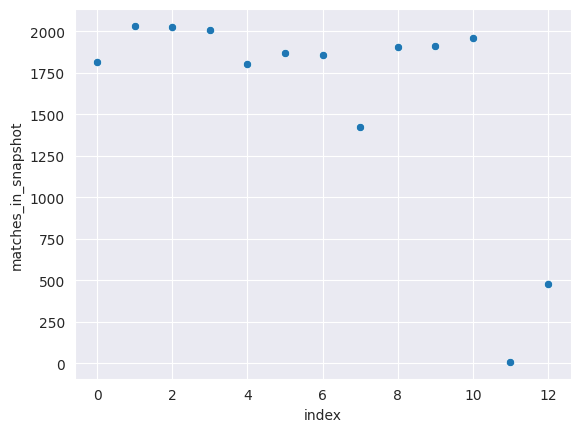

In [32]:
da = DataAcquisition()
df = da.get_data(FROM_CSV, fname="../resources/other_leagues.csv")

# see how many matches occupy each graph snapshot
df['DT'] = pd.to_datetime(df['DT'], format="%Y-%m-%d %H:%M:%S")

start_date = min(df['DT'])
end_date = max(df['DT'])
print(start_date, end_date)
delta = timedelta(days=365) # 1 season duration is about 6 months, then there are 6 months when no league tournaments are played
snapshots = []

while start_date <= end_date:
    snapshots.append(df[((start_date + delta >= df['DT']) & (start_date <= df['DT']))].shape[0])
    start_date += delta
    
sns.scatterplot(x="index", y="matches_in_snapshot", data=pd.DataFrame(snapshots, columns=["matches_in_snapshot"]).reset_index())

    

We can see that in each snapshot (representing 1 year), there are about 1800 matches in selected leagues altogether. That should be enough information for the graph neural network to learn from. But we need to try that first. We can also see some weird behaviour in the last two snapshots. Let's just ignore them for now and get better dataset later.

<Axes: xlabel='index', ylabel='matches_in_snapshot'>

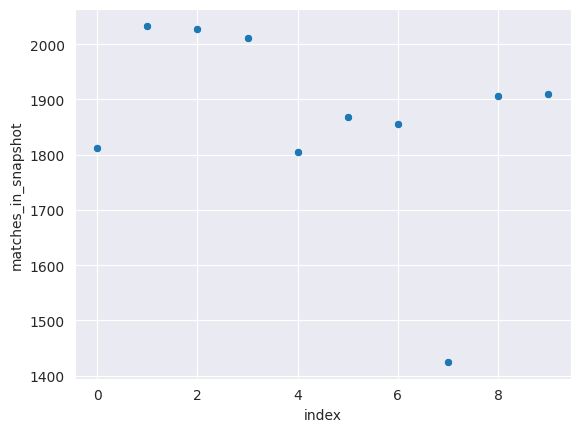

In [33]:
start_date = min(df['DT'])
df = df[(df['DT'] < start_date + 10 * delta)]
end_date = max(df['DT'])

snapshots = []

while start_date <= end_date:
    snapshots.append(df[((start_date + delta >= df['DT']) & (start_date <= df['DT']))].shape[0])
    start_date += delta
    
sns.scatterplot(x="index", y="matches_in_snapshot", data=pd.DataFrame(snapshots, columns=["matches_in_snapshot"]).reset_index())


Normally methods showcased bellow are called from data_transform.transform() method, but in our case we want to see how they work


In [34]:
# constructor of DataTransformation class drops columns that are not used by our models
data_transform = DataTransformation(df, timedelta(365))

data_transform.df.head(10)

,League,DT,Home,Away,Winner,Home_points,Away_points
329,NBL,2022-05-26 18:00:00,Opava,Nymburk,away,65,87
330,NBL,2022-05-24 17:00:00,Nymburk,Opava,away,110,65
331,NBL,2022-05-23 18:00:00,Brno,Usti n. Labem,home,71,67
332,NBL,2022-05-22 17:00:00,Opava,Nymburk,home,78,76
333,NBL,2022-05-21 18:00:00,Usti n. Labem,Brno,away,77,82
334,NBL,2022-05-20 17:00:00,Nymburk,Opava,home,99,72
335,NBL,2022-05-19 18:00:00,Brno,Usti n. Labem,away,80,84
336,NBL,2022-05-10 18:00:00,Opava,Brno,home,83,66
337,NBL,2022-05-09 18:00:00,Usti n. Labem,Nymburk,home,64,102
338,NBL,2022-05-08 18:00:00,Usti n. Labem,Nymburk,home,75,100


### 1.1 map teams to unique ids and match outcomes to integer values

| Winner | Integer value in table | 
|:-------|:----------------------:|
| Home   |           2            | 
| Away   |           0            | 
| Draw   |           1            | 

In [35]:
data_transform._create_teams_mapping()
data_transform._map_match_outcomes(verbose=True)
data_transform.df.head(10)

2024-02-23 19:09:01.332 | INFO     | data_management.data_transformation:_map_match_outcomes:60 - There are 10987 home wins, 6 draws and 7655 away wins in the dataset


,League,DT,Home,Away,Winner,Home_points,Away_points
329,NBL,2022-05-26 18:00:00,0,1,0,65,87
330,NBL,2022-05-24 17:00:00,1,0,0,110,65
331,NBL,2022-05-23 18:00:00,2,3,2,71,67
332,NBL,2022-05-22 17:00:00,0,1,2,78,76
333,NBL,2022-05-21 18:00:00,3,2,0,77,82
334,NBL,2022-05-20 17:00:00,1,0,2,99,72
335,NBL,2022-05-19 18:00:00,2,3,0,80,84
336,NBL,2022-05-10 18:00:00,0,2,2,83,66
337,NBL,2022-05-09 18:00:00,3,1,2,64,102
338,NBL,2022-05-08 18:00:00,3,1,2,75,100


### 1.2 Extract node features (Optional, may not be needed)

recall that these are:

| Feature id     |     0     |     1      |      2      |    3     |     4      |      5      | 
|:---------------|:---------:|:----------:|:-----------:|:--------:|:----------:|:-----------:|
| Nodes Features | home wins | home draws | home losses | away win | away draws | away losses | 

All of these features are dynamic - they accumulate over time during snapshots. In our models we want to try to predict with and without those features

NOTE: The features are normalized between 0 and 1.

In [36]:
node_features = data_transform._extract_node_features(discount_factor=0.75, use_draws=True, verbose=False)

print("Number of snapshots (league years):", len(node_features))
print(f"In each snapshot there are {node_features[0].shape[0]} nodes (teams) with {node_features[0].shape[1]} features")
node_features[-1][:5]

Number of snapshots (league years): 10
In each snapshot there are 203 nodes (teams) with 6 features


array([[0.52235105, 0.        , 0.51112335, 0.54582008, 0.31640625,
        0.42195352],
       [0.7139069 , 0.        , 0.38525953, 0.44175845, 0.        ,
        0.47133948],
       [0.59814493, 0.        , 0.41463418, 0.66773865, 0.        ,
        0.27241926],
       [0.56004713, 1.        , 0.40784751, 0.55640596, 0.        ,
        0.37526511],
       [0.4117578 , 0.        , 0.16875874, 0.31721538, 0.        ,
        0.16104285]])

### 1.3 Create Edges and extract their features; Extract labels

There is just one edge feature: winner of the mathc (0 - home, 1 - draw, 2 - away). In order to predict outcomes, later, we can encode this in a one-hot representation or normalize it.

meaning: 

|      Edge feature      | home win  |   draw    | away win  | 
|:----------------------:|:---------:|:---------:|:---------:|
|     dataset value      |     2     |     1     |     0     |
|    normalized value    |     2     |    0.5    |     0     |
| one-hot representation | (0, 0, 1) | (0, 1, 0) | (1, 0, 0) |

node labels = ranking of the teams. 
We will simply compute labels for each time step. For simplicity, team with the most wins has rank 1 in each league in dataset.
NOTE labels from step n+1 are targets for step n.
We will also normalize those labels 

In [37]:
edges, edge_features, labels, points = data_transform._extract_dynamic_edges_and_labels(one_hot=True)

edges[0], edge_features[0], labels[0], points[0],edge_features[0].shape, edges[0].shape, labels[0].shape, points[0].shape

(array([[  0,   1,   2, ...,  61, 160, 102],
        [  1,   0,   3, ...,  75, 152,  25]]),
 array([[1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        ...,
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.]]),
 array([0.        , 0.8168468 , 0.05263158, 0.21052632, 0.10526316,
        0.15789474, 0.31578947, 0.73684211, 0.42105263, 0.47368421,
        0.63157895, 0.89473684, 0.36842105, 0.57894737, 0.84210526,
        0.78947368, 0.94736842, 1.        , 0.68421053, 0.14492985,
        0.40530563, 0.11538462, 0.91208791, 0.73966714, 0.28777473,
        0.33276099, 0.10735135, 0.03846154, 0.04464286, 0.12913928,
        0.76923077, 0.56833791, 0.92307692, 0.73076923, 0.46153846,
        0.41414835, 0.51614011, 0.84615385, 0.0161953 , 0.5       ,
        0.34615385, 0.88289835, 0.53846154, 0.42307692, 0.69230769,
        0.65384615, 0.72608418, 0.50063776, 0.85460892, 0.14285714,
        0.44802296, 0.21428571, 0.20758929, 0.02933673, 0.32142857,
        0.824

### 1.5 Creating graph representation for Pytorch geometric temporal

now we have everything we need to create our dynamic graph

In [38]:
i = 5
print(f"""Example of graph snapshot {i}: 
      Node feature shape: {node_features[i].shape} 
      Edge index shape: {edges[i].shape} 
      Edge feature shape: {edge_features[i].shape} 
      Labels shape: {labels[i].shape},
      Match_points: {points[i].shape}
      """)

Example of graph snapshot 5: 
      Node feature shape: (203, 6) 
      Edge index shape: (2, 1805) 
      Edge feature shape: (1805, 3) 
      Labels shape: (203,),
      Match_points: (1805, 2)
      


In [39]:
# finally we can create our dataset iterator
from torch_geometric_temporal import DynamicGraphTemporalSignal

dataset = DynamicGraphTemporalSignal(
    edges, edge_features, node_features, labels
)
print(dataset.snapshot_count)

10


### 1.6 All of this is done by get_dataset() method of DataTransformation

In [40]:
df = df[(df['League'] != 'EuroLeague') & (df['League'] != 'EuroCup')] 
df = df.reset_index()

transform = DataTransformation(df, timedelta(365))
dataset = transform.get_dataset(node_f_extract=False, edge_f_one_hot=True)

print(dataset.snapshot_count)

10


# Models
---------------------

## 2 GCONVCheb

Graph Chebychev convolution model

First model we plan to test

In [41]:
from models.GCONVCheb import *
from trainer import Trainer

team_count = transform.num_teams

# We will use the default implemented setting: 
#
# GCONVLSTM(self, team_count: int,
#                 embed_dim: int = 10,
#                 dense_dims: tuple[int] = (8, 8, 8, 8, 8),
#                 conv_out_dim: int = 16,
#                 dropout_rate: float = 0.1,
#                 activation: str = 'relu',
#                 K: int = 5):
model = GCONVCheb(team_count)
model

GCONVCheb(
  (act_fn): ReLU()
  (embedding): Embedding(135, 20)
  (dense_sequence): Sequential(
    (lin0): Linear(in_features=32, out_features=8, bias=True)
    (act0): ReLU()
    (dropout0): Dropout(p=0.1, inplace=False)
    (lin1): Linear(in_features=8, out_features=8, bias=True)
    (act1): ReLU()
    (dropout1): Dropout(p=0.1, inplace=False)
    (lin2): Linear(in_features=8, out_features=8, bias=True)
    (act2): ReLU()
    (dropout2): Dropout(p=0.1, inplace=False)
    (lin3): Linear(in_features=8, out_features=8, bias=True)
    (act3): ReLU()
    (dropout3): Dropout(p=0.1, inplace=False)
    (lin4): Linear(in_features=8, out_features=8, bias=True)
    (act4): ReLU()
    (dropout4): Dropout(p=0.1, inplace=False)
    (lin5): Linear(in_features=8, out_features=3, bias=True)
    (act5): ReLU()
    (dropout5): Dropout(p=0.1, inplace=False)
  )
  (out_layer): Softmax(dim=1)
)

### 2.1 Training

In [42]:
trainer = Trainer(dataset, model)
training_accuracy = trainer.train(epochs=100, verbose=True)

2024-02-23 19:09:02.162 | INFO     | trainer:train:56 - [TRN] Epoch: 0, training loss: 2.173, training accuracy: 54.90% 
2024-02-23 19:09:02.255 | INFO     | trainer:train:56 - [TRN] Epoch: 1, training loss: 2.171, training accuracy: 54.68% 
2024-02-23 19:09:02.353 | INFO     | trainer:train:56 - [TRN] Epoch: 2, training loss: 2.170, training accuracy: 54.44% 
2024-02-23 19:09:02.453 | INFO     | trainer:train:56 - [TRN] Epoch: 3, training loss: 2.168, training accuracy: 54.97% 
2024-02-23 19:09:02.545 | INFO     | trainer:train:56 - [TRN] Epoch: 4, training loss: 2.167, training accuracy: 54.36% 
2024-02-23 19:09:02.635 | INFO     | trainer:train:56 - [TRN] Epoch: 5, training loss: 2.165, training accuracy: 54.72% 
2024-02-23 19:09:02.733 | INFO     | trainer:train:56 - [TRN] Epoch: 6, training loss: 2.163, training accuracy: 54.68% 
2024-02-23 19:09:02.832 | INFO     | trainer:train:56 - [TRN] Epoch: 7, training loss: 2.161, training accuracy: 54.68% 
2024-02-23 19:09:02.928 | INFO  

Let's visualize trainning accuracy over time

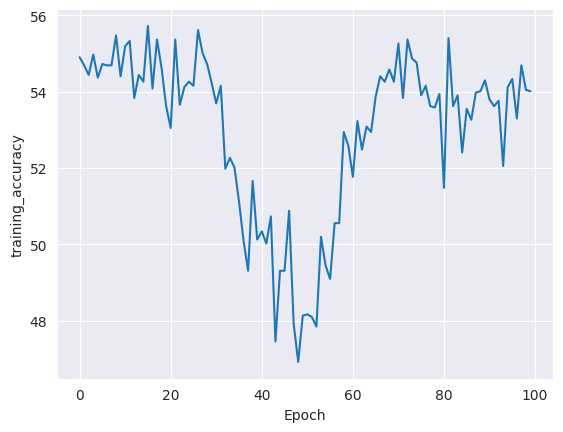

In [43]:
import matplotlib.pyplot as plt
ax = sns.lineplot(x="index", y="training_accuracy", data=pd.DataFrame(training_accuracy, columns=["training_accuracy"]).reset_index())
ax.set(xlabel="Epoch")
plt.show()

### 2.2 Testing

In [44]:
trainer.test(verbose=True)

2024-02-23 19:09:11.931 | INFO     | trainer:test:75 - [TST] Testing accuracy: 59.48%


0.5947819740923189

# Ratings
------------------------------

# 3 Elo


In [47]:
# dummy dataset
from datetime import datetime
import numpy as np
import torch
from models.ratings.manual.elo import *

delta = timedelta(days=365)
delta2 = timedelta(days=366)
now = datetime.now()
data = pd.DataFrame({'DT': [*(3 * [now]), *(3 * [now - delta2]), *(3 * [now - 2 * delta2]), *(3 * [now - 3 * delta2])], 
                     'Home': ['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C'],
                     'Away': ['B', 'C', 'A', 'C', 'A', 'B', 'B', 'C', 'A', 'C', 'A', 'B'],
                     'Winner': ['home', 'away', 'away', 'home', 'away', 'away', 'home', 'home', 'away', 'home', 'away', 'home'],
                     'Home_points': [10, 5, 15, 12, 15, 6, 20, 10, 10, 14, 3, 12],
                     'Away_points': [4, 8, 17, 10, 16, 14, 18, 9, 15, 0, 11, 4],
                     'League': [*(12 * ['liga'])],
                     })

transform2 = DataTransformation(data, timedelta(days=365))
dts = transform2.get_dataset(edge_f_one_hot=True)

def train_elo(train_dataset, model, epochs: int = 100, verbose: bool = False):
    torch.set_printoptions(precision=8) 
    training_accuracy = []
    loss_fn = torch.nn.MSELoss
    
    E_HS = []
    elos = []
    pts = []
    
    for epoch in range(epochs):
        model.train()
        accuracy, loss, count = 0, 0, 0
        iter = 0
        for time, snapshot in enumerate(train_dataset):
            # pass through network has to be only one by one in order to compute elo correctly
            matches = snapshot.edge_index
            match_points = snapshot.match_points
            for m in range(matches.shape[1]):
                match = matches[:, m]
                y_hat = model(match)
                y = np.array(snapshot.edge_attr[m, :])  # edge weight encodes the match outcome
                
                E_HS.append(y_hat)
                
                elos_b4 = (model.rating[model.home], model.rating[model.away])
                  
                target = np.argmax(y) / 2.
                prediction = y_hat
                accuracy += 1 if abs(target - prediction) < 0.33 else 0
    
                loss += np.mean((prediction-target)**2)
                
                point_diff = int(abs(match_points[m, 0] - match_points[m, 1]))
                result = [target, point_diff]
                
                model.backward(result)
                
                elos.append((elos_b4, (model.rating[model.home], model.rating[model.away])))
                pts.append(((match_points[m, 0], match_points[m, 1]), (model.home, model.away)))
                
                # if verbose:
                #    rating = model.rating[:5] if len(model.rating) >= 5 else model.rating
                #    print(f"Neuralnet {iter}, rating: {rating}, E_H = {y_hat}; {target}")
                iter += 1
                
            count += matches.shape[1]

        if verbose:
            rating = model.rating[:5] if len(model.rating) >= 5 else model.rating
            print(f'[TRN] '
                  f' Epoch: {epoch}, training loss: {loss:.3f}, '
                        f'training accuracy: {accuracy/count * 100:.2f}% \n'
                        f'ratings (first 5): {rating}')
        training_accuracy.append(accuracy/count * 100)
    
    return np.array(training_accuracy), E_HS, elos, pts


def compute_elo(matches: pd.DataFrame, mapping, elo_base: int = 1000, gamma: float = 2, c: float = 3, d: float = 500, k: float = 3, verbose: bool = False):
    elo = np.zeros((len(mapping), )) + elo_base
    E_HS = []
    elos = []
    for i in range(len(matches.index)):
        match_i = matches.iloc[i]
        h_i = mapping[match_i['Home']]
        a_i = mapping[match_i['Away']]
        
        E_h = 1 / (1 + np.power(c, ((elo[a_i] - elo[h_i]) / d)))
        S_h = 1. if match_i['Winner'] == 'home' else 0. if match_i['Winner'] == 'away' else 1/2
        
        E_HS.append(E_h)
        
        elos_b4 = (elo[h_i], elo[a_i])
        
        h_points = match_i['Home_points']
        a_points = match_i['Away_points']
        
        delta = abs(h_points - a_points)
        update = k * ((1 + delta)**gamma) * (S_h - E_h)
        
        elo[h_i] += update
        elo[a_i] -= update
        
        elos.append((elos_b4, (elo[h_i], elo[a_i])))
        
        if verbose:
            print(f"iteration {i}, rating: {elo}, E_H = {E_h}; {S_h}")
    return np.array(elo), E_HS, elos
    
    
print('Computed elo Dummy: ', compute_elo(data, transform2.team_mapping, verbose=False))
eloDummy = EloLate(team_count=transform2.num_teams, gamma=2., c=3., d=500., k=3.)
acc_dummy = train_elo(dts, eloDummy, 1, True)

print()
print('----------------------------------------')
print()
computed, E_HS_comp, elos_comp = compute_elo(df, transform.team_mapping, 1000, 2., 3., 500., 3.)

print()
elo = EloLate(team_count=transform.num_teams, gamma=2., c=3., d=500., k=3.)
acc_late, E_HS_net, elos_net, pts = train_elo(dataset, elo, 1, True)

err = False
for i in range(len(computed)):
    cmp = computed[transform.team_mapping[transform.inv_team_mapping[i]]]
    net = elo.rating[transform.team_mapping[transform.inv_team_mapping[i]]]
    if cmp != net:
        print(rf'ERROR on index {i}:: {cmp} / {net}')
        err = True
if not err:
    print("SUCCESS: Computed elo is the same as Elo from NN")


#inv_map = {v: k for k, v in transform.team_mapping.items()}
#for i in range(len(E_HS_net)):
#    eq = E_HS_net[i] == E_HS_comp[i]
#    
#    str_i = f'{i}:: net: {E_HS_net[i]:2.2f}, comp: {E_HS_comp[i]:2.2f};;; elo net / comp: {elos_net[i][1][0]:10.2f} / {elos_comp[i][1][0]:10.2f} :: {elos_net[i][1][1]:10.2f} / {elos_comp[i][1][1]:10.2f}'
    
#    print(str_i if eq else '----------> ' + str_i + f''' {df.iloc[i]["Home"]}  home_pts: {df.iloc[i]["Home_points"]}, {df.iloc[i]["Away"]}  away_pts: {df.iloc[i]["Away_points"]};;;;;;;;; pts net: {pts[i][0][0]}, {pts[i][0][1]}''')
#    if not eq:
#        print(f'elo before: {elos_net[i][0][0]:10.2f} / {elos_comp[i][0][0]:10.2f} :: {elos_net[i][0][1]:10.2f} / {elos_comp[i][0][1]:10.2f}')
#        print(f'Teams: home {inv_map[int(pts[i][1][0])]} away {inv_map[int(pts[i][1][1])]}')
#        break 


Computed elo Dummy:  (array([1450.41466185,  783.32864878,  766.25668937]), [0.5, 0.4597135195287363, 0.47177715569548395, 0.5421467296792649, 0.39493208333191193, 0.5532294506957484, 0.5379443202146263, 0.5865272540941598, 0.36183188188500987, 0.6768094454034466, 0.3183888246975012, 0.31720839917433186], [((1000.0, 1000.0), (1073.5, 926.5)), ((926.5, 1000.0), (904.4337510626207, 1022.0662489373793)), ((1022.0662489373793, 1073.5), (1009.3282657336013, 1086.237983203778)), ((1086.237983203778, 1009.3282657336013), (1098.6000215024378, 996.9662274349414)), ((904.4337510626207, 1098.6000215024378), (899.6945660626377, 1103.3392065024207)), ((996.9662274349414, 899.6945660626377), (862.5314709158746, 1034.1293225817046)), ((1103.3392065024207, 1034.1293225817046), (1115.8147098566258, 1021.6538192274995)), ((1021.6538192274995, 862.5314709158746), (1026.6154921783695, 857.5697979650045)), ((857.5697979650045, 1115.8147098566258), (818.4919547214234, 1154.892553100207)), ((1154.89255310020